# ClusterMap for STARmap human cardiac organoid dataset

In [1]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io

### Read spots and dapi image

In [2]:
### set file folder
filepath='./datasets/STARmap_human_cardiac_organoid/'

### read dapi: col, row, z
dapi = tifffile.imread(filepath+'round1_dapi.tiff')
dapi = np.transpose(dapi, (1,2,0))

### read spots
mat = scipy.io.loadmat(filepath+'allPoints.mat')

### read gene id in mat['allReads']
gene=mat['allReads'].astype('int')
gene=gene-min(gene)+1

### get gene annotation for barcode in mat['allReads']
genes=pd.DataFrame(['TNNI1','MYH7','MYL7','ATP2A2','NANOG','EOMES','CS44','TBXT'])

### read spots in mat['allPoints']
spots = pd.DataFrame(mat['allPoints'], columns = ['spot_location_1','spot_location_2','spot_location_3'])
spots['gene']=gene

In [3]:
### set radius parameters
xy_radius=10
z_radius=7

### Instantiate model

In [4]:
### instantiate model
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=z_radius,fast_preprocess=False)

100%|██████████| 97/97 [00:21<00:00,  4.46it/s]


In [5]:
model.spots

,spot_location_1,spot_location_2,spot_location_3,gene
0,45,541,1,1
1,55,490,5,1
2,85,495,5,1
3,236,893,2,1
4,241,904,1,1
...,...,...,...,...
55166,295,743,90,8
55167,829,672,88,8
55168,216,314,90,8
55169,217,733,90,8


### Show spatial distribution of marker genes

In [6]:
###select gene markers
marker_genes=['TNNI1','NANOG','CS44']
genes_list=list(genes[0])

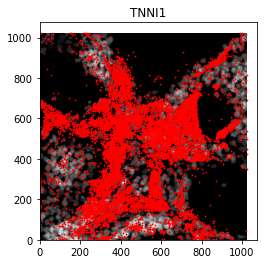

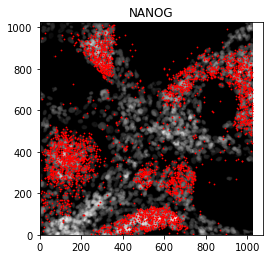

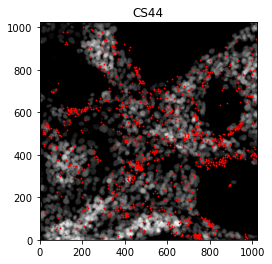

In [7]:
model.plot_gene(marker_genes,genes_list,figsize=(4,4),s=0.6)

### Pre-processing

In [8]:
### pct_filter: percent of spots filtered out
### default: filter 10% spots out
pct_filter=0.1
model.preprocess(pct_filter)

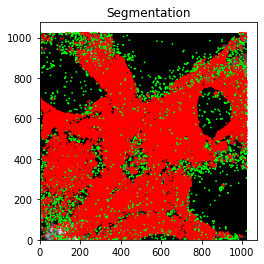

In [9]:
### plot preprocessing results
model.spots['is_noise']=model.spots['is_noise']+1
model.plot_segmentation(figsize=(4,4),s=0.6,method='is_noise',
                        cmap=np.array(((0,1,0),(1,0,0))),
                        plot_dapi=True)
model.spots['is_noise']=model.spots['is_noise']-min(model.spots['is_noise'])-1

### Cell segmentation

In [10]:
%%time

### segmentation
model.min_spot_per_cell=5
model.segmentation(cell_num_threshold=0.001,dapi_grid_interval=4,add_dapi=True,use_genedis=True)

# res_over_dapi_erosion(self.spots, self.dapi_binary)

After denoising, mRNA spots: 51481
Computing NGC coordinates


51481it [00:00, 109527.09it/s]


After adding DAPI points, all spots:275827
DPC
  Compute spatial distance


275827it [00:02, 112181.94it/s]


  Compute genetic distance


275827it [00:07, 36754.93it/s]


  Compute density rho and the nearest distance


275827it [00:09, 30023.82it/s]
100%|██████████| 111/111 [00:00<00:00, 363.96it/s]


  Find cell number:1495.0


100%|██████████| 275827/275827 [00:00<00:00, 759958.99it/s]


Postprocessing
CPU times: user 1min 40s, sys: 7.13 s, total: 1min 47s
Wall time: 1min 53s


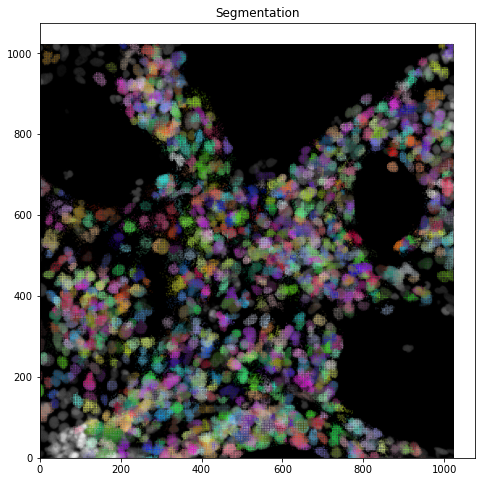

In [11]:
### plot cell segmentation results in spots (colored by cells)
model.plot_segmentation(figsize=(8,8),s=0.005,plot_with_dapi=True,plot_dapi=True, show=False)
plt.show()

Creat cell convex hull
Used 1072 / 1125


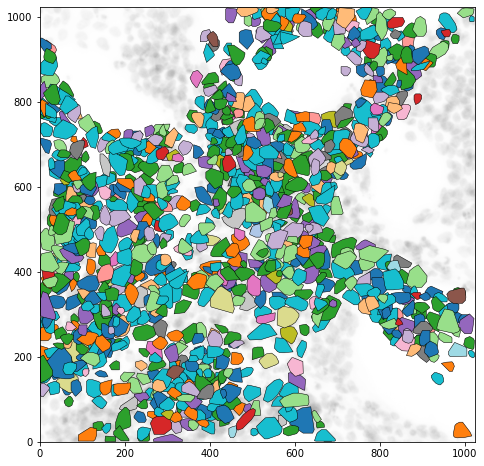

In [14]:
model.create_convex_hulls(figscale=8,plot_with_dapi=True)

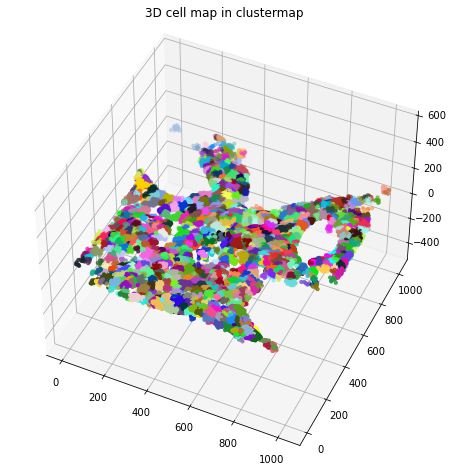

In [15]:
###plot cells in 3D
model.plot_segmentation_3D(figsize=(8,8),elev=45, azim=-65)

### Save cell segmentation results

In [16]:
path_save = filepath+'spots_all.csv'
model.save_segmentation(path_save)

In [17]:
np.savetxt(filepath+"cellcenter.csv",model.cellcenter,delimiter=",")

### Perform cell typing (based on Scanpy package)

In [18]:
path_save = filepath+'spots_all.csv'
savespots=pd.read_csv(path_save)
model.spots=savespots
model.cellcenter = np.genfromtxt(filepath+"cellcenter.csv", delimiter=',')

In [19]:
model.spots

,spot_location_1,spot_location_2,spot_location_3,gene,is_noise,clustermap
0,45,541,1,1,-1,-1.0
1,55,490,5,1,0,-1.0
2,85,495,5,1,0,190.0
3,236,893,2,1,0,4.0
4,241,904,1,1,-1,-1.0
...,...,...,...,...,...,...
55166,295,743,90,8,-1,-1.0
55167,829,672,88,8,-1,-1.0
55168,216,314,90,8,0,1134.0
55169,217,733,90,8,-1,-1.0


In [20]:
cellid='clustermap'
geneid='gene'
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

cluster_method='aggre'

In [21]:
model.create_cell_adata(cellid,geneid,gene_list,genes,num_dims)

/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


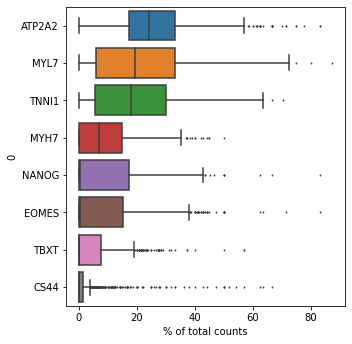

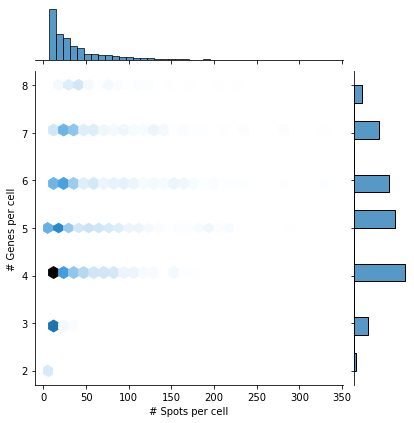

In [25]:
model.cell_preprocess()

In [26]:
model.cell_typing(cluster_method=cluster_method)

clustering method: aggre
Get 3 clusters


/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


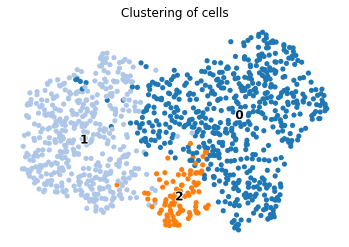

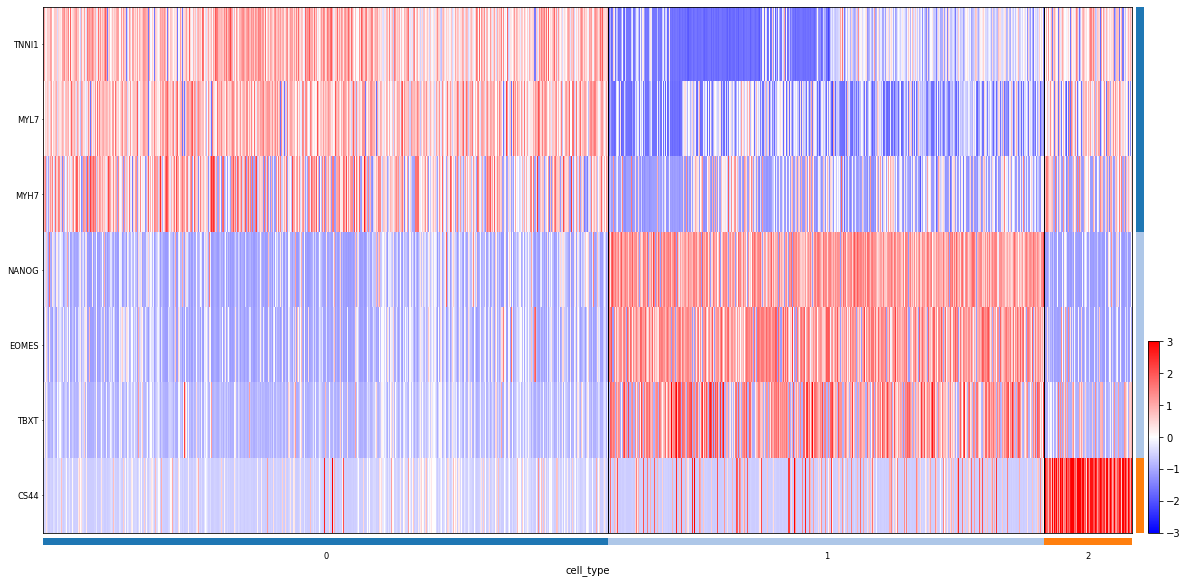

0 ['TNNI1', 'MYL7', 'MYH7', 'ATP2A2', 'CS44']
1 ['NANOG', 'EOMES', 'TBXT', 'ATP2A2', 'CS44']
2 ['CS44', 'ATP2A2', 'TNNI1', 'MYL7', 'MYH7']


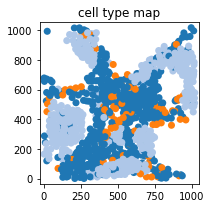

In [27]:
cluster_pl=model.plot_cell_typing()

In [28]:
model.map_cell_type_to_spots(cellid)

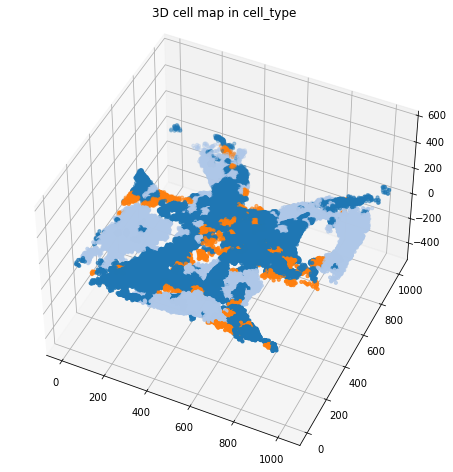

In [29]:
###plot cells in 3D
cluster_pl = sns.color_palette('tab20',len(model.cell_adata.obs['cell_type'].unique()))
model.plot_segmentation_3D(figsize=(8,8),elev=45, azim=-65,method='cell_type',
                          cmap=np.array(cluster_pl))